# Modélisation

### Préparation des features pour la modélisation

#### A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation. OK fait
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer. OK fait
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn. Ok fait
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé). Ok fait
* Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


In [176]:
building_consumption_anexplo = pd.read_csv("building_consumption_anexplo.csv")

In [177]:
print(building_consumption_anexplo.columns.tolist())

['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [178]:
# 1 si un second usage existe
building_consumption_anexplo["has_second_use"] = (
    building_consumption_anexplo["SecondLargestPropertyUseTypeGFA"].fillna(0) > 0
).astype("int8")

# Part de GFA du 1er usage (protège division par zéro)
building_consumption_anexplo["share_primary_gfa"] = (
    building_consumption_anexplo["LargestPropertyUseTypeGFA"] / building_consumption_anexplo["PropertyGFABuilding(s)"]
).where(building_consumption_anexplo["PropertyGFABuilding(s)"].ne(0))

# Part de GFA du 2e usage (protège division par zéro)
building_consumption_anexplo["share_second_gfa"] = (
    building_consumption_anexplo["SecondLargestPropertyUseTypeGFA"] / building_consumption_anexplo["PropertyGFABuilding(s)"]
).where(building_consumption_anexplo["PropertyGFABuilding(s)"].ne(0))

# Part du parking dans la surface totale (protège division par zéro)
building_consumption_anexplo["parking_share"] = (
    building_consumption_anexplo["PropertyGFAParking"] / building_consumption_anexplo["PropertyGFATotal"]
).where(building_consumption_anexplo["PropertyGFATotal"].ne(0))

# 1 si site multi-bâtiments
building_consumption_anexplo["is_multi_building"] = (
    building_consumption_anexplo["NumberofBuildings"].fillna(1) > 1
).astype("int8")

# Présence d’électricité (pas la quantité)
building_consumption_anexplo["has_electricity"] = (
    (building_consumption_anexplo["Electricity(kWh)"].fillna(0) > 0) |
    (building_consumption_anexplo["Electricity(kBtu)"].fillna(0) > 0)
).astype("int8")

# Présence de gaz (pas la quantité)
building_consumption_anexplo["has_gas"] = (
    (building_consumption_anexplo["NaturalGas(therms)"].fillna(0) > 0) |
    (building_consumption_anexplo["NaturalGas(kBtu)"].fillna(0) > 0)
).astype("int8")

# Présence de vapeur (pas la quantité)
building_consumption_anexplo["has_steam"] = (
    building_consumption_anexplo["SteamUse(kBtu)"].fillna(0) > 0
).astype("int8")


#### supprimer toutes les colonnes peu pertinentes pour la modélisation.

In [179]:
building_consumption_anexplo.drop(columns=[
    'ENERGYSTARScore',
    'ComplianceStatus', 
    'DefaultData', 
    'OSEBuildingID', 
    'PropertyName', 
    'TaxParcelIdentificationNumber', 
    'SteamUse(kBtu)', 
    'Electricity(kBtu)', 
    'Electricity(kWh)', 
    'NaturalGas(therms)', 
    'NaturalGas(kBtu)',   
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)', 
    'SiteEnergyUse(kBtu)', 
    'SiteEnergyUseWN(kBtu)',
    'PropertyGFATotal',
    'TotalGHGEmissions',
    'SiteEUIWN(kBtu/sf)',
    'GHGEmissionsIntensity',
    'ListOfAllPropertyUseTypes'
], inplace=True)

print(building_consumption_anexplo.columns.tolist())


['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'has_second_use', 'share_primary_gfa', 'share_second_gfa', 'parking_share', 'is_multi_building', 'has_electricity', 'has_gas', 'has_steam']


### Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 

#### Préparation à une matrice de corrélation

In [180]:
# Types de toutes les colonnes
building_consumption_anexplo.dtypes


BuildingType                        object
PrimaryPropertyType                 object
Address                             object
ZipCode                            float64
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
SiteEUI(kBtu/sf)                   float64
has_second_use                        int8
share_primary_gfa                  float64
share_second_gfa                   float64
parking_share                      float64
is_multi_building                     int8
has_electri

In [181]:
building_consumption_anexplo["CouncilDistrictCode"] = building_consumption_anexplo["CouncilDistrictCode"].astype("string")
building_consumption_anexplo["ZipCode"] = building_consumption_anexplo["ZipCode"].astype("Int64").astype("string")
building_consumption_anexplo["NumberofBuildings"] = building_consumption_anexplo["NumberofBuildings"].astype("Int64")

print(building_consumption_anexplo.columns.tolist())


['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'has_second_use', 'share_primary_gfa', 'share_second_gfa', 'parking_share', 'is_multi_building', 'has_electricity', 'has_gas', 'has_steam']


In [182]:
s = building_consumption_anexplo["NumberofBuildings"]
print("dtype:", s.dtype)
print("nunique:", s.nunique(dropna=True))
print("std:", s.std())
print("% NaN:", s.isna().mean())
print(s.value_counts(dropna=False).head())


dtype: Int64
nunique: 9
std: 0.7796337953896965
% NaN: 0.0014184397163120568
NumberofBuildings
1    1327
0      42
2      14
3      10
5       7
Name: count, dtype: Int64


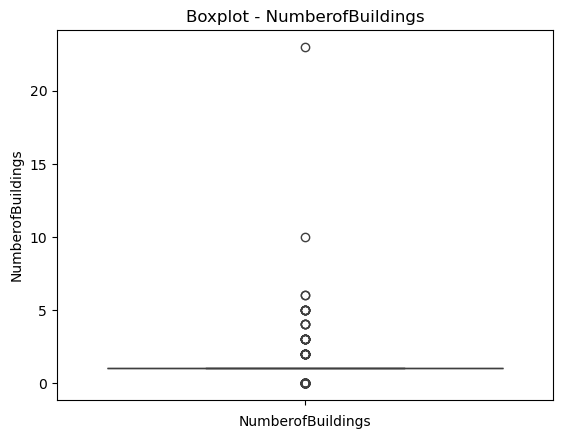

In [183]:
s = building_consumption_anexplo["NumberofBuildings"].dropna()

plt.figure()
sns.boxplot(y=s)
plt.xlabel("NumberofBuildings")
plt.title("Boxplot - NumberofBuildings")
plt.show()

building_consumption_anexplo.loc[building_consumption_anexplo["NumberofBuildings"] == 0, "NumberofBuildings"] = 1


In [184]:
display(building_consumption_anexplo.columns)

colonnes_autorisees = [
    "Latitude",
    "Longitude",
    "YearBuilt",
    "SiteEUI(kBtu/sf)",
    "NumberofBuildings",
    "has_second_use",
    "share_primary_gfa",
    "share_second_gfa",
    "parking_share",
    "is_multi_building",
    "has_electricity",
    "has_gas",
    "has_steam",
    "NumberofFloors",     
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA", 
    "SecondLargestPropertyUseTypeGFA", 
]

cols = [c for c in colonnes_autorisees if c in building_consumption_anexplo.columns]
cols = [c for c in cols if building_consumption_anexplo[c].dtype.kind in "if"]
corr = building_consumption_anexplo[cols].corr(method="pearson").round(2)
print("Colonnes utilisées pour la corrélation :", cols)
display(corr)
display(building_consumption_anexplo["NumberofBuildings"])


Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'SiteEUI(kBtu/sf)', 'has_second_use', 'share_primary_gfa',
       'share_second_gfa', 'parking_share', 'is_multi_building',
       'has_electricity', 'has_gas', 'has_steam'],
      dtype='object')

Colonnes utilisées pour la corrélation : ['Latitude', 'Longitude', 'YearBuilt', 'SiteEUI(kBtu/sf)', 'NumberofBuildings', 'has_second_use', 'share_primary_gfa', 'share_second_gfa', 'parking_share', 'is_multi_building', 'has_electricity', 'has_gas', 'has_steam', 'NumberofFloors', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA']


,Latitude,Longitude,YearBuilt,SiteEUI(kBtu/sf),NumberofBuildings,has_second_use,share_primary_gfa,share_second_gfa,parking_share,is_multi_building,has_electricity,has_gas,has_steam,NumberofFloors,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA
Latitude,1.00,-0.11,0.06,0.07,0.02,-0.04,0.03,0.07,0.11,0.02,-0.08,-0.00,-0.03,0.08,-0.02,-0.01,0.04
Longitude,-0.11,1.00,0.01,-0.03,-0.01,-0.06,0.02,-0.04,-0.05,0.04,0.03,0.05,-0.00,-0.08,-0.01,-0.01,-0.05
YearBuilt,0.06,0.01,1.00,0.12,0.05,-0.02,0.17,0.21,0.32,0.09,-0.01,-0.05,-0.14,-0.00,0.20,0.25,0.30
SiteEUI(kBtu/sf),0.07,-0.03,0.12,1.00,0.07,0.12,-0.06,0.02,0.15,0.06,0.08,0.13,0.10,0.14,0.08,0.06,0.09
NumberofBuildings,0.02,-0.01,0.05,0.07,1.00,-0.05,0.06,-0.06,-0.02,0.64,0.01,0.04,-0.02,-0.06,0.14,0.16,-0.02
has_second_use,-0.04,-0.06,-0.02,0.12,-0.05,1.00,-0.36,0.36,0.24,-0.07,0.06,-0.05,0.02,0.20,0.07,-0.07,0.25
share_primary_gfa,0.03,0.02,0.17,-0.06,0.06,-0.36,1.00,0.26,0.33,0.11,-0.00,-0.02,-0.04,-0.01,-0.05,0.26,0.11
share_second_gfa,0.07,-0.04,0.21,0.02,-0.06,0.36,0.26,1.00,0.55,-0.06,-0.01,-0.02,-0.05,0.06,-0.03,0.04,0.58
parking_share,0.11,-0.05,0.32,0.15,-0.02,0.24,0.33,0.55,1.00,-0.01,0.04,-0.13,-0.02,0.30,0.14,0.25,0.48
is_multi_building,0.02,0.04,0.09,0.06,0.64,-0.07,0.11,-0.06,-0.01,1.00,0.02,0.04,-0.02,-0.06,0.08,0.10,-0.02


0       1
1       1
2       1
3       1
4       1
       ..
1405    1
1406    1
1407    1
1408    1
1409    1
Name: NumberofBuildings, Length: 1410, dtype: Int64

 * Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 


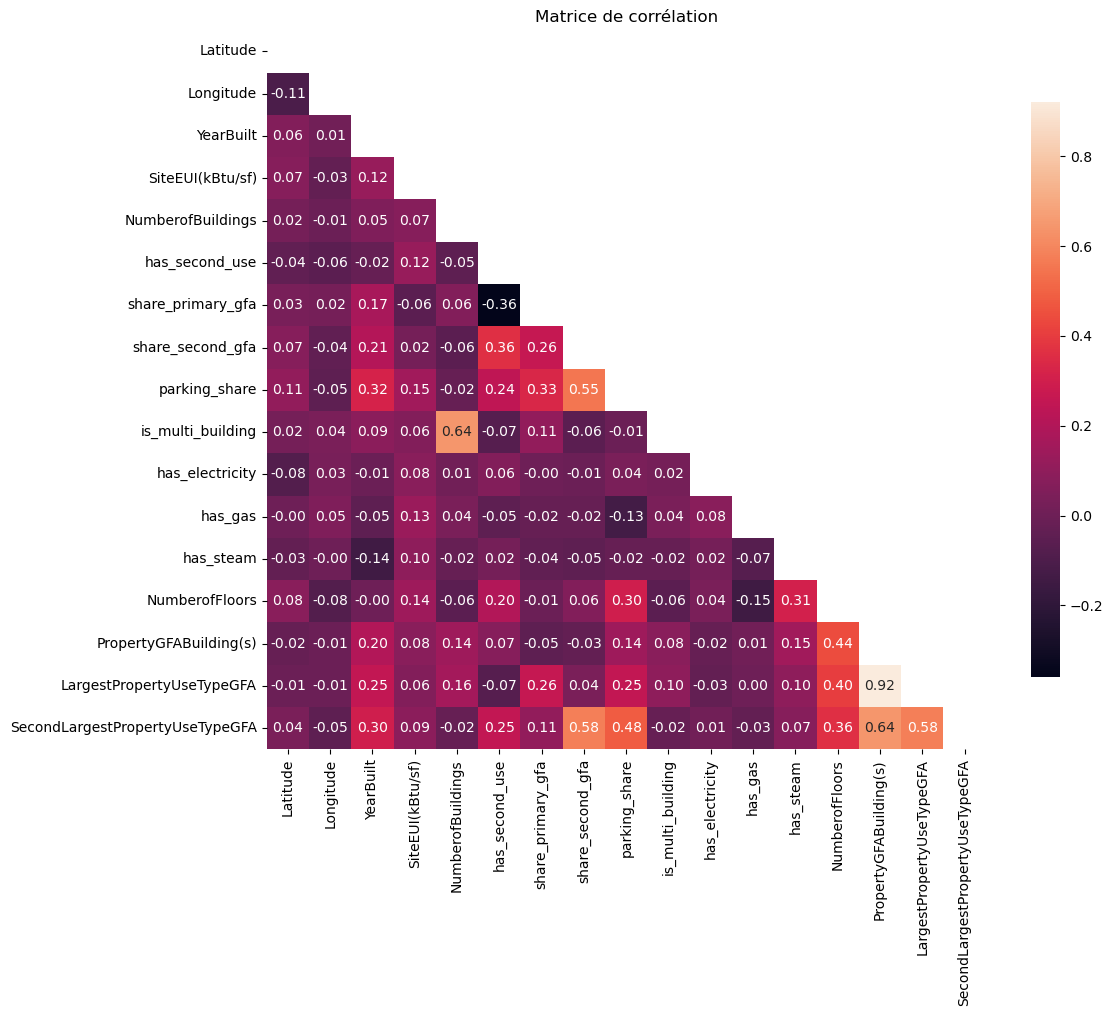

In [185]:
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

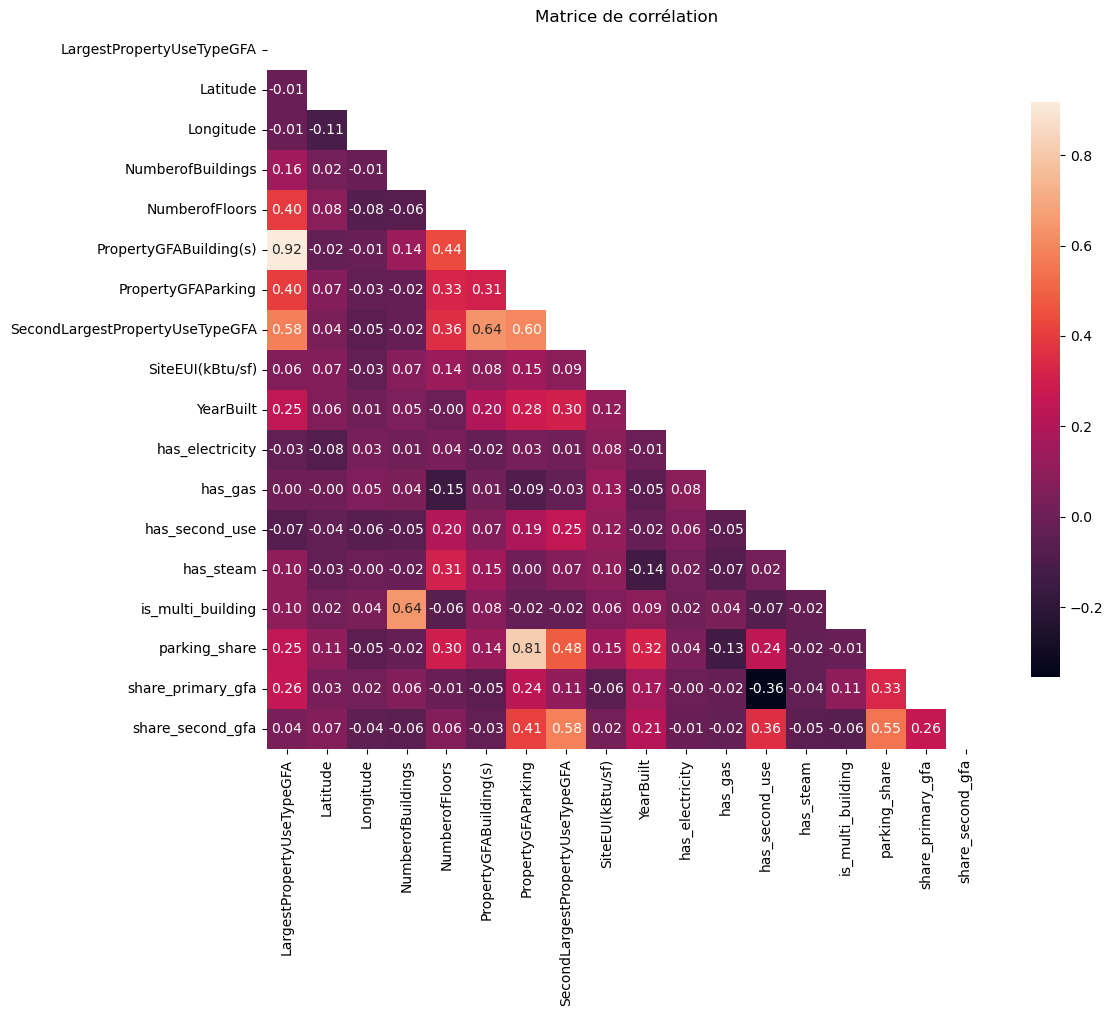

In [ ]:
# Colonnes numériques pertinentes
cols_num = building_consumption_anexplo.select_dtypes(include="number").columns.difference(
    ["OSEBuildingID", "ZipCode", "CouncilDistrictCode"]
)
cols_num = [c for c in cols_num if building_consumption_anexplo[c].nunique(dropna=True) > 1]

# Matrice et heatmap
corr = building_consumption_anexplo[cols_num].corr(method="pearson")
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

Il en reste des corrélés mais ils restent tout de même interessants

On continue le nettoyage et description

### Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.

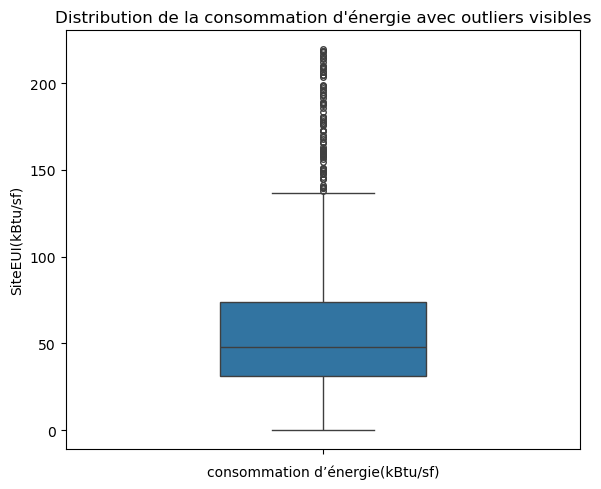

In [187]:
plt.figure(figsize=(6,5))
sns.boxplot(y=building_consumption_anexplo["SiteEUI(kBtu/sf)"], width=0.4, fliersize=4)
plt.xlabel("consommation d’énergie(kBtu/sf)")
plt.title("Distribution de la consommation d'énergie avec outliers visibles")
plt.tight_layout()
plt.show()


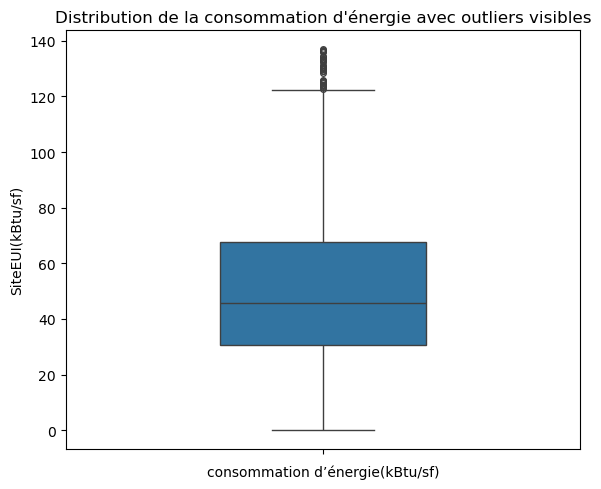

In [ ]:
# Suppression des valeurs aberrantes sur  par méthode IQR
q1 = building_consumption_anexplo["SiteEUI(kBtu/sf)"].quantile(0.25)
q3 = building_consumption_anexplo["SiteEUI(kBtu/sf)"].quantile(0.75)
iqr = q3 - q1
lb = q1 - 1.5 * iqr
ub = q3 + 1.5 * iqr
building_consumption_anexplo = building_consumption_anexplo[building_consumption_anexplo["SiteEUI(kBtu/sf)"].between(lb, ub)]

# Boxplot après nettoyage
plt.figure(figsize=(6,5))
sns.boxplot(y=building_consumption_anexplo["SiteEUI(kBtu/sf)"], width=0.4, fliersize=4)
plt.xlabel("consommation d’énergie(kBtu/sf)")
plt.title("Distribution de la consommation d'énergie avec outliers visibles")
plt.tight_layout()
plt.show()


Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).


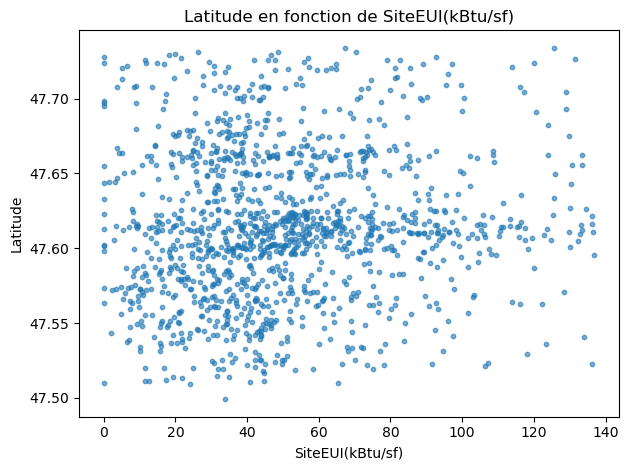

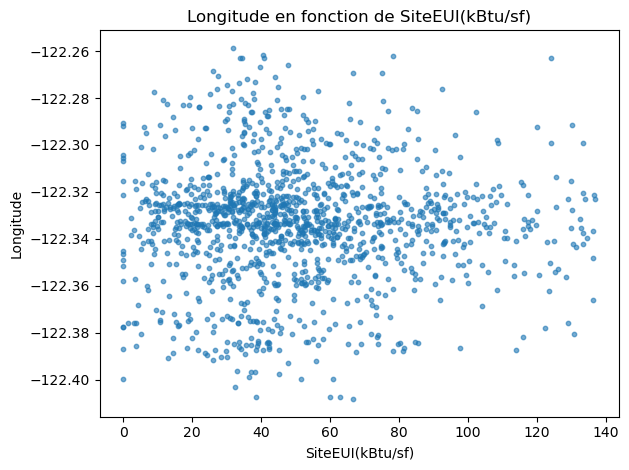

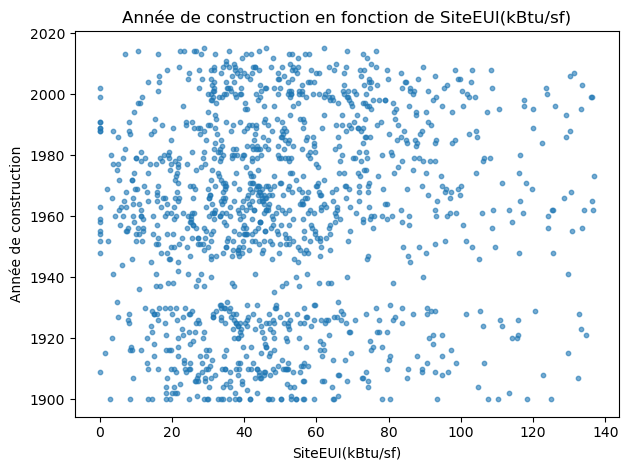

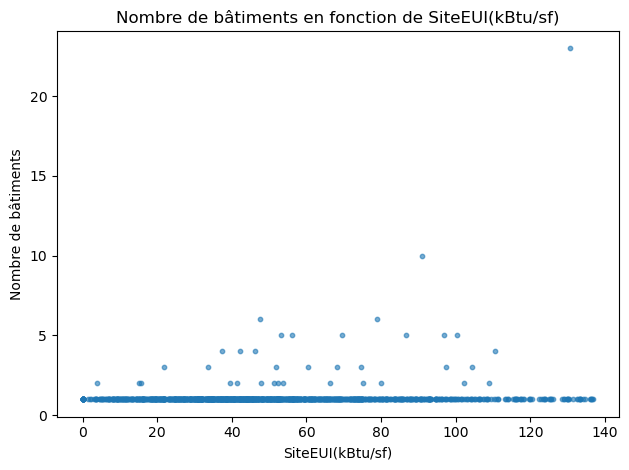

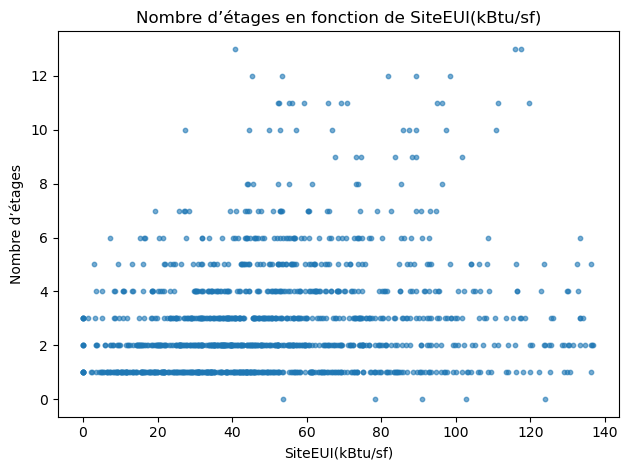

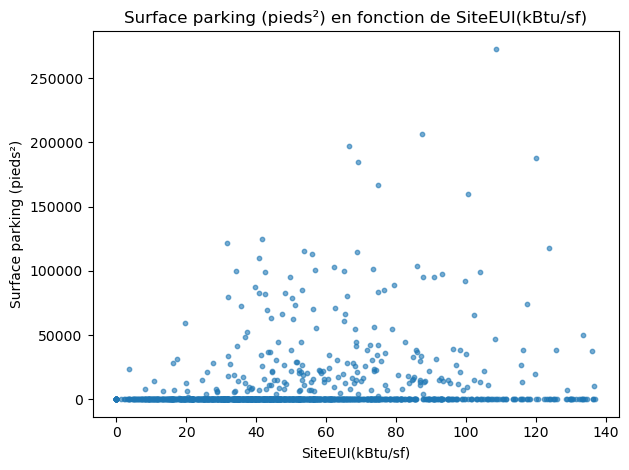

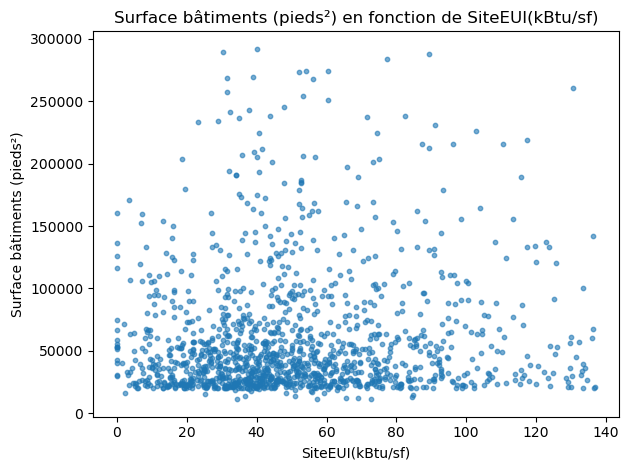

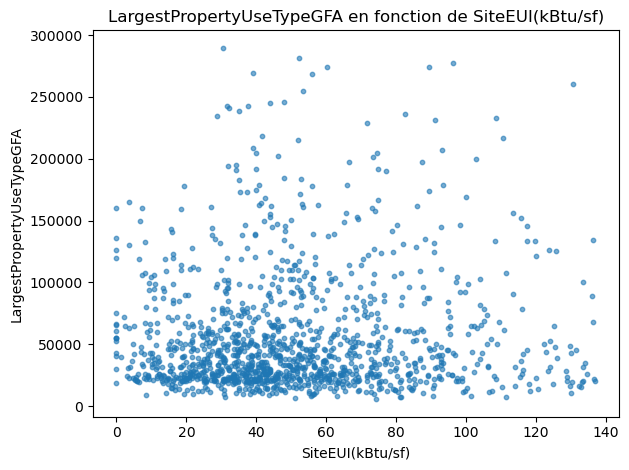

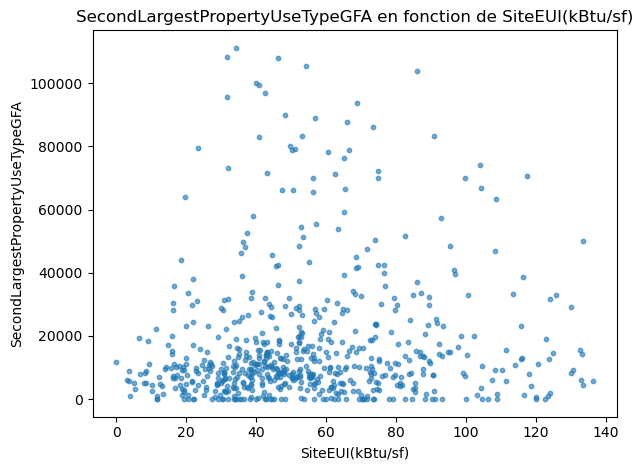

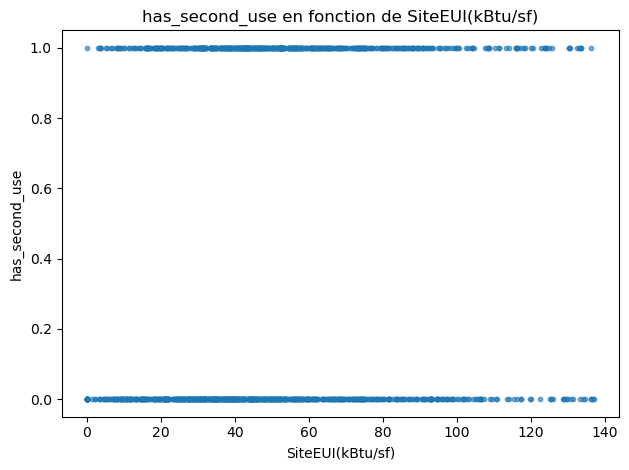

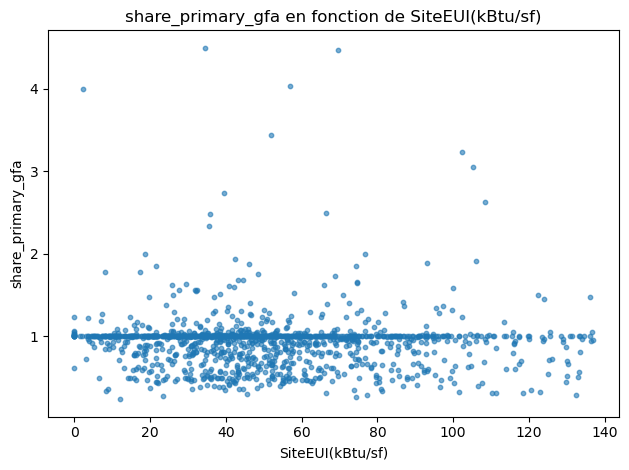

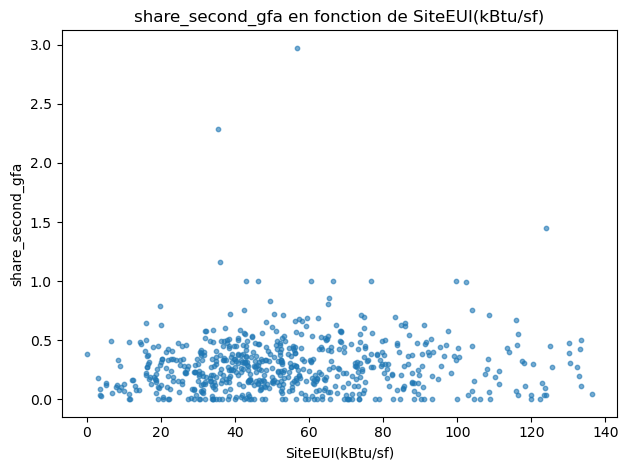

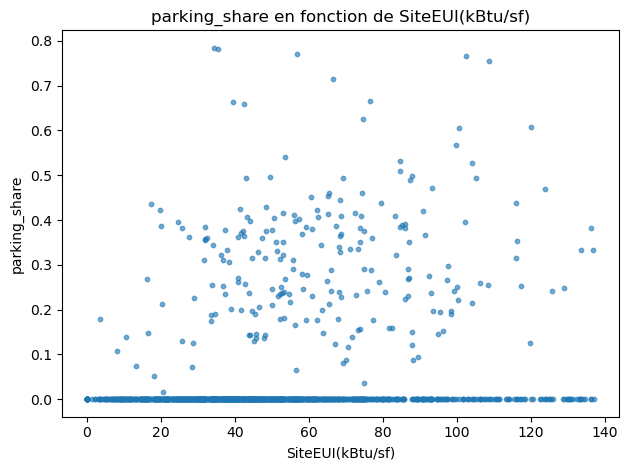

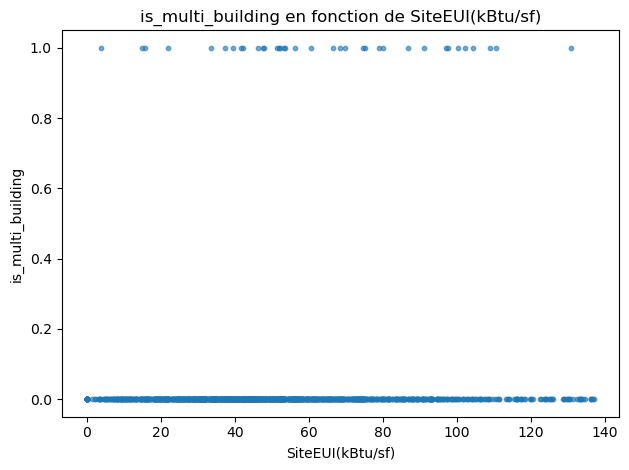

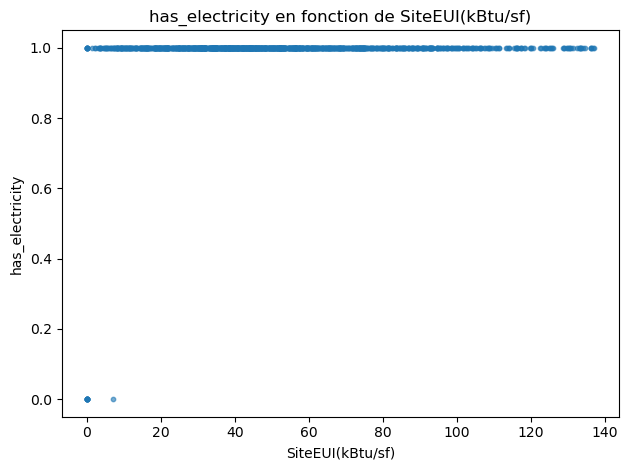

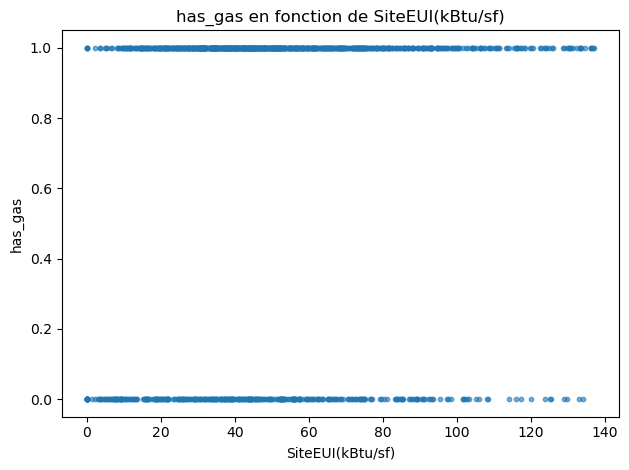

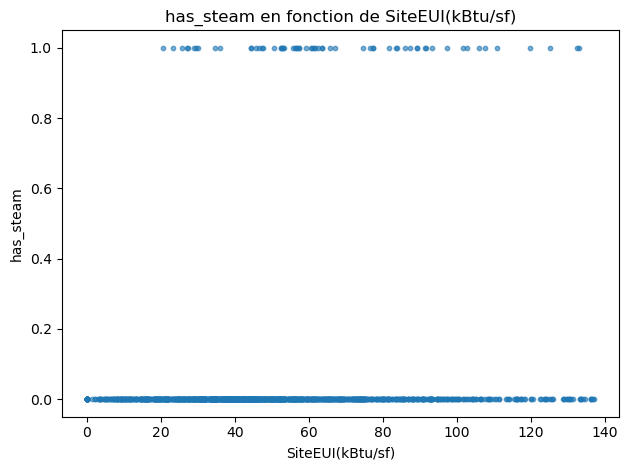

In [189]:
# Abscisse fixée
abscisse = "SiteEUI(kBtu/sf)"

# Candidats automatiques en ordonnée, numériques, hors identifiants et abscisse
exclusions = {"OSEBuildingID", "ZipCode", "CouncilDistrictCode", abscisse}
candidats = [
    c for c in building_consumption_anexplo.select_dtypes(include="number").columns
    if c not in exclusions and building_consumption_anexplo[c].nunique(dropna=True) > 1
]

# Libellés en français
libelles = {
    "PropertyGFATotal": "Surface totale (pieds²)",
    "PropertyGFABuilding(s)": "Surface bâtiments (pieds²)",
    "PropertyGFAParking": "Surface parking (pieds²)",
    "NumberofFloors": "Nombre d’étages",
    "YearBuilt": "Année de construction", 
    "NumberofBuildings" : "Nombre de bâtiments",
    
}

# Tracé, une figure par candidat
assert abscisse in building_consumption_anexplo.columns, f"Abscisse absente: {abscisse}"
for y in candidats:
    data_xy = building_consumption_anexplo[[abscisse, y]].dropna()
    if data_xy.empty:
        continue
    plt.figure()
    plt.scatter(data_xy[abscisse], data_xy[y], s=10, alpha=0.6)
    plt.xlabel(libelles.get(abscisse, abscisse))
    plt.ylabel(libelles.get(y, y))
    plt.title(f"{libelles.get(y, y)} en fonction de {libelles.get(abscisse, abscisse)}")
    plt.tight_layout()
    plt.show()

In [190]:
idx = building_consumption_anexplo["NumberofFloors"].idxmax()
ligne_max = building_consumption_anexplo.loc[idx]
print(ligne_max)
building_consumption_anexplo.loc[idx, "NumberofFloors"] = 2

BuildingType                       NonResidential
PrimaryPropertyType                  Large Office
Address                              1200 3rd Ave
ZipCode                                     98104
CouncilDistrictCode                             7
Neighborhood                             DOWNTOWN
Latitude                                 47.60741
Longitude                              -122.33565
YearBuilt                                    1921
NumberofBuildings                               1
NumberofFloors                                 13
PropertyGFAParking                              0
PropertyGFABuilding(s)                     189175
LargestPropertyUseType                     Office
LargestPropertyUseTypeGFA                151740.0
SecondLargestPropertyUseType                Other
SecondLargestPropertyUseTypeGFA           12645.0
SiteEUI(kBtu/sf)                       115.800003
has_second_use                                  1
share_primary_gfa                        0.802114


In [191]:
print(building_consumption_anexplo.columns.tolist())

['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'has_second_use', 'share_primary_gfa', 'share_second_gfa', 'parking_share', 'is_multi_building', 'has_electricity', 'has_gas', 'has_steam']


Création de colonnes interessantes

### Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target). 

In [192]:
cible = "SiteEUI(kBtu/sf)"

colonnes_a_exclure = ['Address',cible]

X = building_consumption_anexplo.drop(columns=[c for c in colonnes_a_exclure])
y = building_consumption_anexplo[cible]

display(X.head())
print(X.info())



,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,has_second_use,share_primary_gfa,share_second_gfa,parking_share,is_multi_building,has_electricity,has_gas,has_steam
0,NonResidential,Large Office,98006,7,DOWNTOWN,47.60604,-122.33948,1918,1,6,...,Adult Education,14621.0,1,0.684677,0.156282,0.135711,0,1,0,1
1,NonResidential,Mixed Use Property,98011,7,DOWNTOWN,47.61056,-122.33661,1909,1,11,...,Multifamily Housing,40878.0,1,0.386361,0.367816,0.000000,0,1,1,0
2,NonResidential,Other,98013,6,NORTHWEST,47.67713,-122.35398,1917,1,2,...,NaN,NaN,0,0.849067,NaN,0.000000,0,1,1,0
3,NonResidential,Small- and Mid-Sized Office,98020,4,LAKE UNION,47.65576,-122.34208,1995,1,3,...,NaN,NaN,0,1.000000,NaN,0.000000,0,1,1,0
4,NonResidential,Small- and Mid-Sized Office,98033,7,MAGNOLIA / QUEEN ANNE,47.62053,-122.35842,1970,1,4,...,Parking,21454.0,1,0.965456,0.426665,0.340231,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 1322 entries, 0 to 1409
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1322 non-null   object 
 1   PrimaryPropertyType              1322 non-null   object 
 2   ZipCode                          1309 non-null   string 
 3   CouncilDistrictCode              1322 non-null   string 
 4   Neighborhood                     1322 non-null   object 
 5   Latitude                         1322 non-null   float64
 6   Longitude                        1322 non-null   float64
 7   YearBuilt                        1322 non-null   int64  
 8   NumberofBuildings                1322 non-null   Int64  
 9   NumberofFloors                   1322 non-null   int64  
 10  PropertyGFAParking               1322 non-null   int64  
 11  PropertyGFABuilding(s)           1322 non-null   int64  
 12  LargestPropertyUseType   

### Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

Export de X pour mieux visualiser

In [203]:
# CSV
X.to_csv("X_export.csv", index=False)
print("Écrit X_export.csv")


Écrit X_export.csv


Encodage

OneHotEncoder méthode

In [204]:
# Colonnes catégorielles explicites
cols_cat = [
    "BuildingType",
    "PrimaryPropertyType",
    "LargestPropertyUseType",
    "ZipCode", 
    "CouncilDistrictCode",
    "SecondLargestPropertyUseType",
    "Neighborhood"
    
]

# On encode uniquement ces colonnes-là
X_OHE = pd.get_dummies(X, columns=cols_cat, drop_first=False)

print("Forme finale de X_OHE :", X_OHE.shape)
display(X_OHE.head())



Forme finale de X_OHE : (1318, 206)


,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,has_second_use,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,47.60604,-122.33948,1918,1,6,14690,93555,64055.0,14621.0,1,...,False,False,False,False,False,False,False,False,False,False
1,47.61056,-122.33661,1909,1,11,0,111137,42939.0,40878.0,1,...,False,False,False,False,False,False,False,False,False,False
2,47.67713,-122.35398,1917,1,2,0,28072,23835.0,0.0,0,...,False,False,False,False,False,True,False,False,False,False
3,47.65576,-122.34208,1995,1,3,0,20410,20410.0,0.0,0,...,False,True,False,False,False,False,False,False,False,False
4,47.62053,-122.35842,1970,1,4,25930,50283,48546.0,21454.0,1,...,False,False,True,False,False,False,False,False,False,False


LabelEncoder

In [205]:
# Méthode 2, Label Encoding sur toutes les catégorielles
X_LE = X.copy()
for c in cols_cat:
    X_LE[c] = LabelEncoder().fit_transform(X_LE[c].astype(str))


Export en csv

In [206]:
X_OHE.to_csv("X_OHE.csv", index=False)
y.to_csv("y.csv", index= False)
